In [91]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [ ]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
from qiskit_ibm_runtime import QiskitRuntimeService #allow me to access the backend
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager # Generate a transpiler based on whatever backend I import

service = QiskitRuntimeService()

# First call my backend and then use the backend to get the all the configurations from the backend to tell my transpiler how to convert the circuit into
# something that can be executed on the device
# backend_name = "ibm_brisbane" # 127 qubit device with pretty good performance
# backend = service.backend(name=backend_name)
backend = service.least_busy(simulator=False, operational=True, min_num_qubits=100)

#create a pass manager by telling optimization level and pass in the backend
# this will then populate the method with everything that needs to be known about the backend like the connectivity in the native gates
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

# qc_transpiled = pass_manager.run(qc)

# Originally, I created operators in order of 0 to 100 but when you map the quantum circuit to device, all the indices get swapped around
# So we need to make sure in here that the indices of the operators get mapped to the right points on the transpiled
# operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators]

In [93]:
backend.name

'ibm_sherbrooke'

In [ ]:
# Borrowed Github open-source sample codes
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

/var/folders/s_/1nmtncvn10v1fdmg7nss082w0000gn/T/ipykernel_45465/2149212773.py:27: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of Qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)


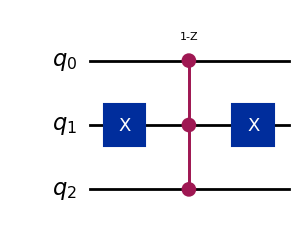

In [108]:
marked_states = ["101"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

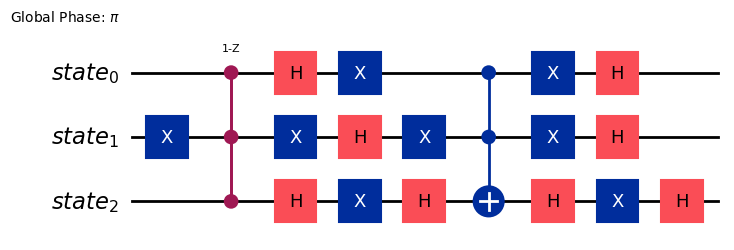

In [109]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [110]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)
print(optimal_num_iterations)

2


In [186]:
optimal_num_iterations = 1

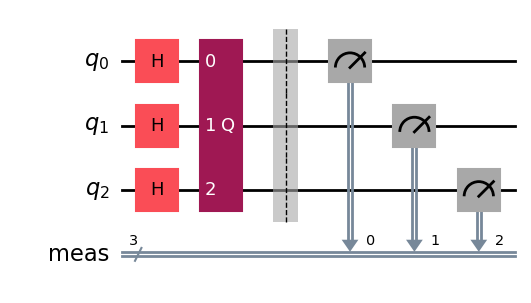

In [187]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

## Step 2: Optimize problem for quantum execution

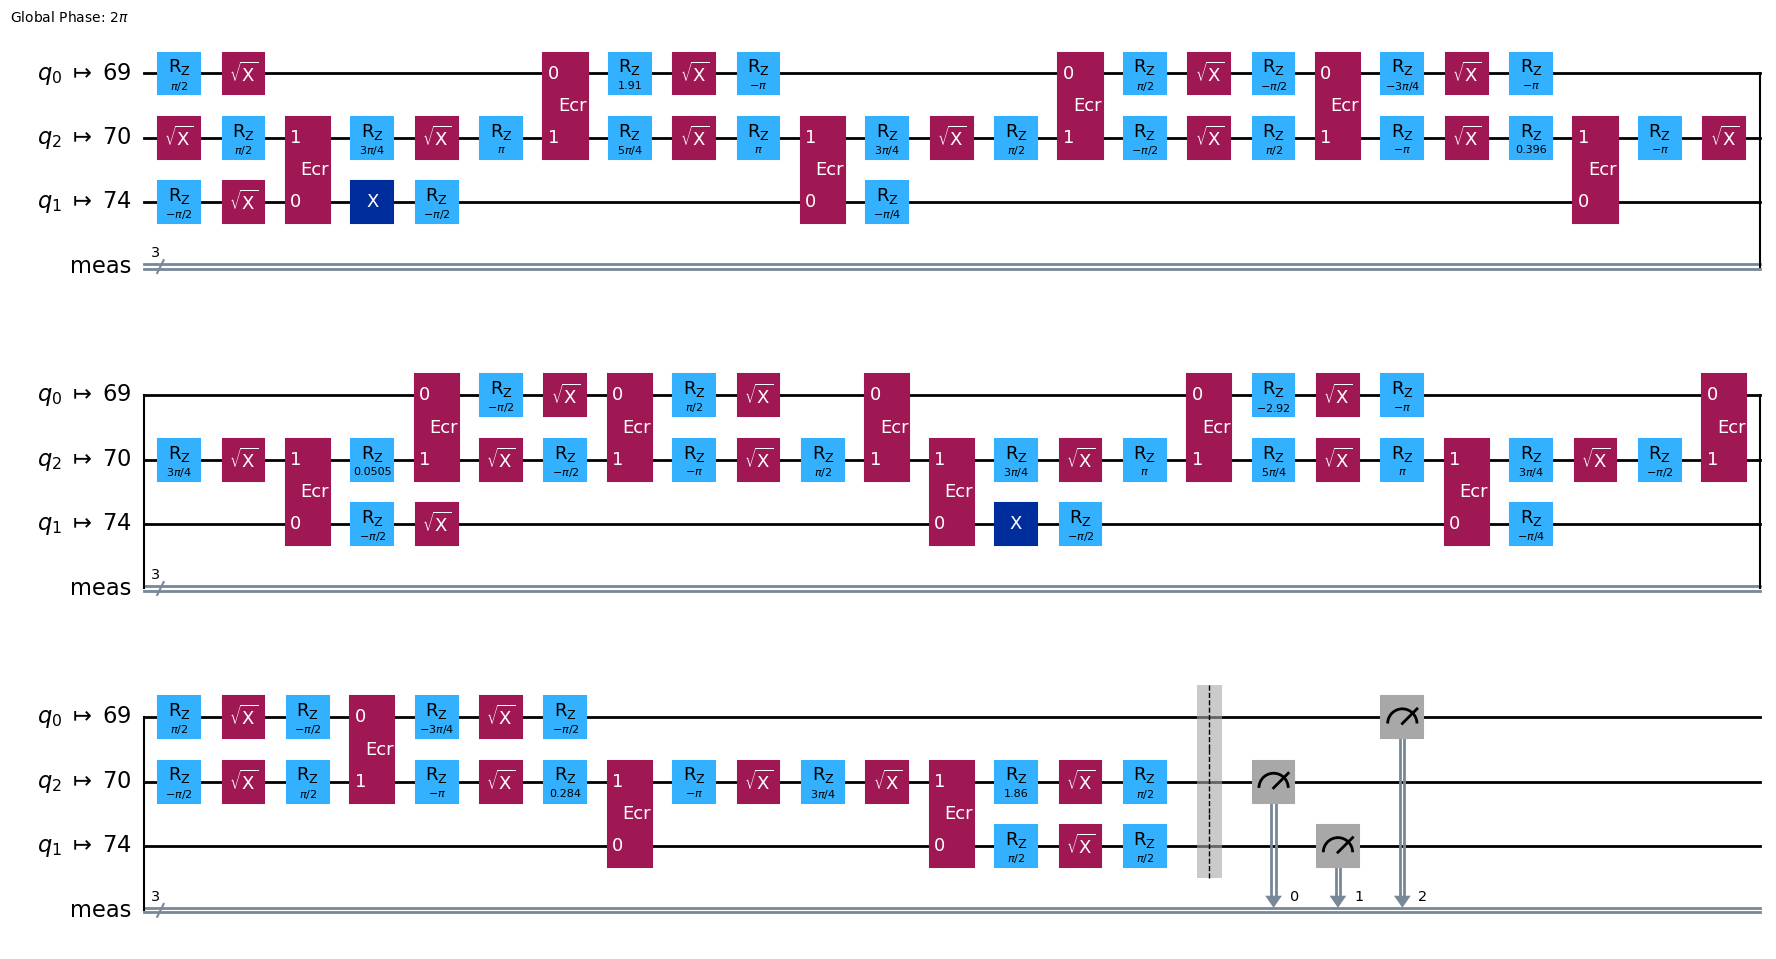

In [188]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

target = backend.target
# pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

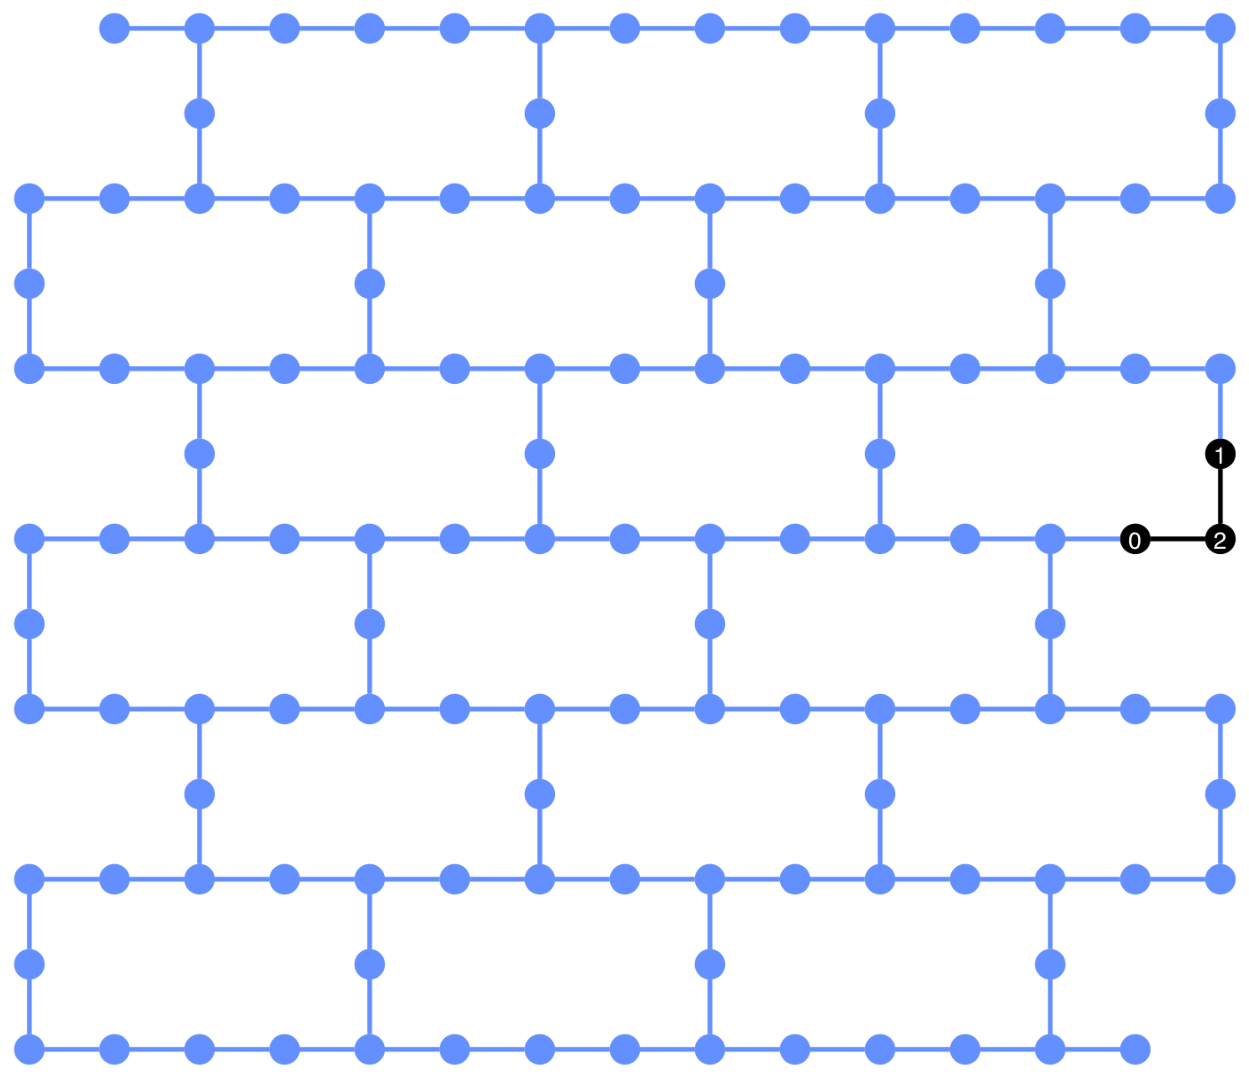

In [189]:
from qiskit.visualization import plot_circuit_layout

plot_circuit_layout(circuit_isa, backend)

In [190]:
# from qiskit.visualization import plot_error_map
# import seaborn as sns

# plot_error_map(backend, figsize=(20,20))

In [ ]:
# from qiskit_ibm_runtime import EstimatorV2 as Estimator
# from qiskit_ibm_runtime import EstimatorOptions

# options = EstimatorOptions()
# options.resilience_level = 1
# options.dynamical_decoupling.enable = True
# options.dynamical_decoupling.sequence_type = "XY4"

# estimator = Estimator(backend, options=options)
# job = estimator.run(circuit_isa)
# pub_result = job.result()[0]
# print(f"Expectation values: {pub_result.data.evs}")

## Step 3: Execute using Qiskit Primitives

In [192]:
# To run on local simulator:
#   1. Use the SatetvectorSampler from qiskit.primitives instead
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000

result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

## Step 4: Post-process and plotting

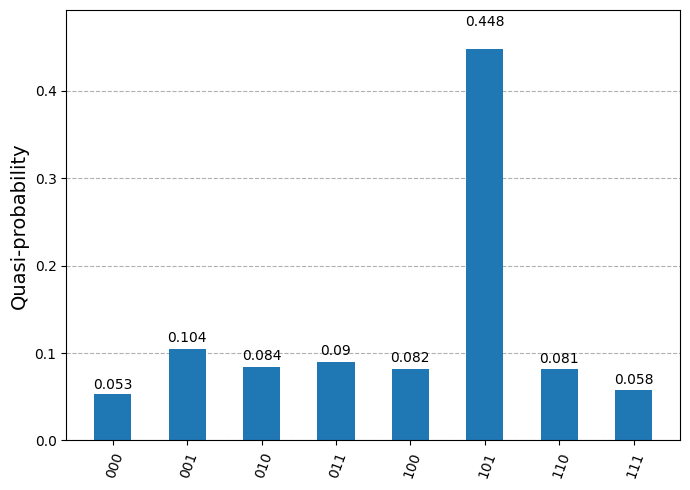

In [193]:
plot_distribution(dist)